In [1]:
import os
import sys
import warnings

import mne
from anlffr.helper import biosemi2mne as bs
from matplotlib import pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi']  = 120

In [2]:
from bdf_preproc import poolBDF
pwd = os.getcwd();

subj = 'S360';
cond = 'YNH';
fmod = 223;

trialID = '*RAM*' + str(fmod) +'*';

EFR = 1; #change to 1 if you want to look at EFRs
local = 0;

if local:
    #Local Storage
    measure_dir = '/mnt/ECF4E22CF4E1F92A/Research/Data_Backup/Pitch_Study/F30_Full_Data/ACC/SNAPLab/';
    
else:
    #Ext Drive
    measure_dir = '/media/sivaprakasaman/AndrewNVME/Pitch_Study/Pitch_Diagnostics_SH_AS/EFR_RAM/Human/';

data_dir = measure_dir+cond+'/'+subj;
out_loc = data_dir + '/Preprocessed';

os.chdir(data_dir);

refchans = ['EXG1','EXG2'];
# refchans = ['EXG3','EXG4'];

if EFR:
    filtband = [60,4000];
    fs_new = 2*filtband[1];

else:
    filtband = [1,25];
    fs_new = 4e3;

raw, eves, files = poolBDF(trialID, refchans, filtband, fs_new = fs_new)
fname = subj+'_RAM_' + str(fmod) +'_EFR_preProcessed.mat';
try:
    os.mkdir('Preprocessed')
except OSError as error:
    print('Directory Present') 

os.chdir(pwd);

['S360_RAM_fmod_223_EFR.bdf', 'S360_RAM_fmod_223_EFR+001.bdf']
Extracting EDF parameters from /media/sivaprakasaman/AndrewNVME/Pitch_Study/Pitch_Diagnostics_SH_AS/EFR_RAM/Human/YNH/S360/S360_RAM_fmod_223_EFR.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8724479  =      0.000 ...  1065.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 130560 (consider using initial_event=True to detect this event)
828 events found
Event IDs: [  1   2 253]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 60 - 4e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwid

Extracting EDF parameters from /media/sivaprakasaman/AndrewNVME/Pitch_Study/Pitch_Diagnostics_SH_AS/EFR_RAM/Human/YNH/S360/S360_RAM_fmod_223_EFR+001.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1843199  =      0.000 ...   225.000 secs...
Re-referencing data to: EXG1 EXG2EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65024 (consider using initial_event=True to detect this event)
173 events found
Event IDs: [1 2]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 60 - 4e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edg

Using matplotlib as 2D backend.
Opening raw-browser...


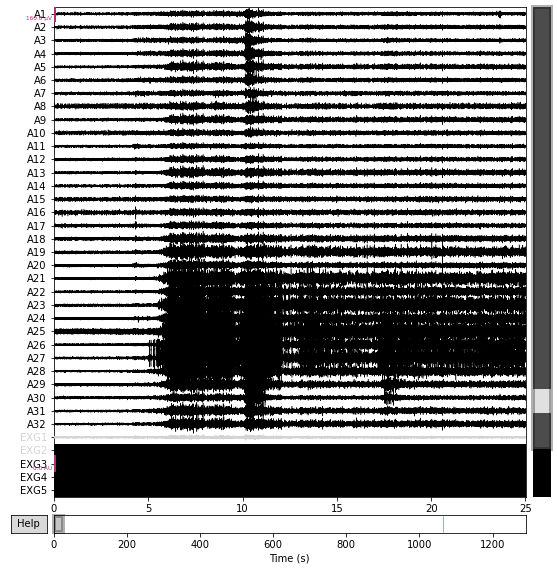

In [3]:
%matplotlib inline
raw.plot(duration = 25.0, scalings = dict(eeg=80e-6), n_channels = 37);

In [4]:
bad_chans = ['EXG3','EXG4','EXG5'];
raw.drop_channels(bad_chans);
raw.info

<Info | 10 non-empty values
 bads: 2 items (EXG1, EXG2)
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 34 EEG, 3 misc, 1 Stimulus
 custom_ref_applied: True
 dig: 43 items (3 Cardinal, 34 EEG, 6 Extra)
 highpass: 60.0 Hz
 lowpass: 1667.0 Hz
 meas_date: 2023-06-26 16:43:49 UTC
 nchan: 38
 projs: []
 sfreq: 8000.0 Hz
>

In [5]:
from anlffr.preproc import find_blinks
from mne import compute_proj_epochs

if not EFR:
    blinks = find_blinks(raw)
    epochs_blinks = mne.Epochs(raw, blinks, event_id=998, baseline=(-0.25, 0.25),
                               reject=dict(eeg=500e-6), tmin=-0.25, tmax=0.25)

    blink_proj = compute_proj_epochs(epochs_blinks, n_eeg=1)
    raw.add_proj(blink_proj)

In [6]:
tbounds = [-0.2,1.2];
bsline = (-.2,0);

pos = 1;
neg = 2;

to_proj = bool(~EFR);

epochs_p = mne.Epochs(raw, eves, event_id=pos, baseline=bsline, proj=to_proj,
                    tmin=tbounds[0], tmax=tbounds[1], reject=dict(eeg=80e-5), verbose = 'ERROR')

epochs_n = mne.Epochs(raw, eves, event_id=neg, baseline=bsline, proj=to_proj,
                    tmin=tbounds[0], tmax=tbounds[1], reject=dict(eeg=80e-5), verbose = 'ERROR');

In [7]:
chan_names = epochs_p.ch_names;
efr_chans = ['A32'];
cort_chans= efr_chans;

if EFR:
#     chans2pick = mne.pick_channels_regexp(chan_names,'A.');
    chans2pick = mne.pick_channels(chan_names,efr_chans);
else:
    chans2pick = mne.pick_channels(chan_names,cort_chans);

In [8]:
all_epochs_mean_cap = epochs_p.get_data();
all_epochs_mean_cap = all_epochs_mean_cap[:,chans2pick,:];
all_epochs_mean_p = np.mean(all_epochs_mean_cap,1);

cap_p = np.mean(all_epochs_mean_p,0);
cap_p_std_err = np.std(all_epochs_mean_p,0)/np.sqrt(np.size(all_epochs_mean_p,0));

all_epochs_mean_cap = epochs_n.get_data();
all_epochs_mean_cap = all_epochs_mean_cap[:,chans2pick,:];
all_epochs_mean_n = np.mean(all_epochs_mean_cap,1);

cap_n = np.mean(all_epochs_mean_n,0);
cap_n_std_err = np.std(all_epochs_mean_n,0)/np.sqrt(np.size(all_epochs_mean_n,0));

Using data from preloaded Raw for 500 events and 11201 original time points ...
    Rejecting  epoch based on EEG : ['A27']
    Rejecting  epoch based on EEG : ['A27']
    Rejecting  epoch based on EEG : ['A25', 'A26', 'A27', 'A29']
    Rejecting  epoch based on EEG : ['A4']
5 bad epochs dropped
Using data from preloaded Raw for 500 events and 11201 original time points ...
    Rejecting  epoch based on EEG : ['A27']
    Rejecting  epoch based on EEG : ['A27']
    Rejecting  epoch based on EEG : ['A27']
    Rejecting  epoch based on EEG : ['A27']
    Rejecting  epoch based on EEG : ['A27']
    Rejecting  epoch based on EEG : ['A4']
    Rejecting  epoch based on EEG : ['A27']
7 bad epochs dropped


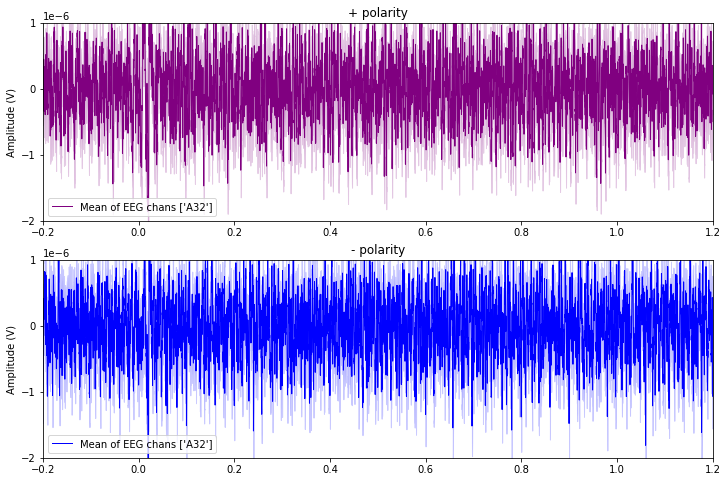

In [9]:
chan_id = np.array(chans2pick);
selected_chans = str([chan_names[index] for index in chan_id]);
tmin = tbounds[0];
t_vect = np.arange(0,np.size(cap_p,0))/fs_new;
t_vect = t_vect + tmin;

plt.rcParams['figure.figsize'] = [12, 8]
#plot params
xlims = tbounds;
# xlims = [0.1,0.8];
ylims = [-2e-6,1e-6];
# ylims = [-9e-7,9e-7];


buff = 0;
plt.figure();
plt.subplot(2,1,1);

plt.plot(t_vect, cap_p-buff,linewidth=1,color = 'purple', label = "Mean of EEG chans "+ selected_chans)
plt.fill_between(t_vect,cap_p+cap_p_std_err-buff,cap_p-cap_p_std_err-buff, color = 'purple', alpha=0.2)

plt.xlim(xlims)
plt.ylim(ylims)
plt.legend(loc=3)
plt.ylabel('Amplitude (V)')
plt.title("+ polarity")

plt.subplot(2,1,2);
plt.plot(t_vect, cap_n-buff,linewidth=1,color = 'blue', label = "Mean of EEG chans "+ selected_chans)
plt.fill_between(t_vect,cap_n+cap_n_std_err-buff,cap_n-cap_n_std_err-buff, color = 'blue', alpha=0.2)

plt.xlim(xlims)
plt.ylim(ylims)
plt.legend(loc=3)
plt.ylabel('Amplitude (V)')
plt.title("- polarity")
plt.rcParams.update({'font.size': 20})
plt.show()

Need more than one channel to make topography for eeg. Disabling interactivity.


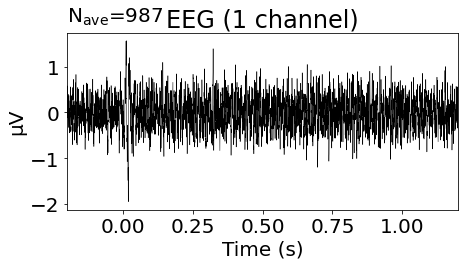

In [10]:
erp_p = epochs_p.average();
erp_n = epochs_n.average();

comb = mne.combine_evoked([erp_p,erp_n],[.5,.5]);
comb.plot(picks = chans2pick);

comb_export = comb.get_data(picks = chans2pick);

<Figure size 864x576 with 0 Axes>

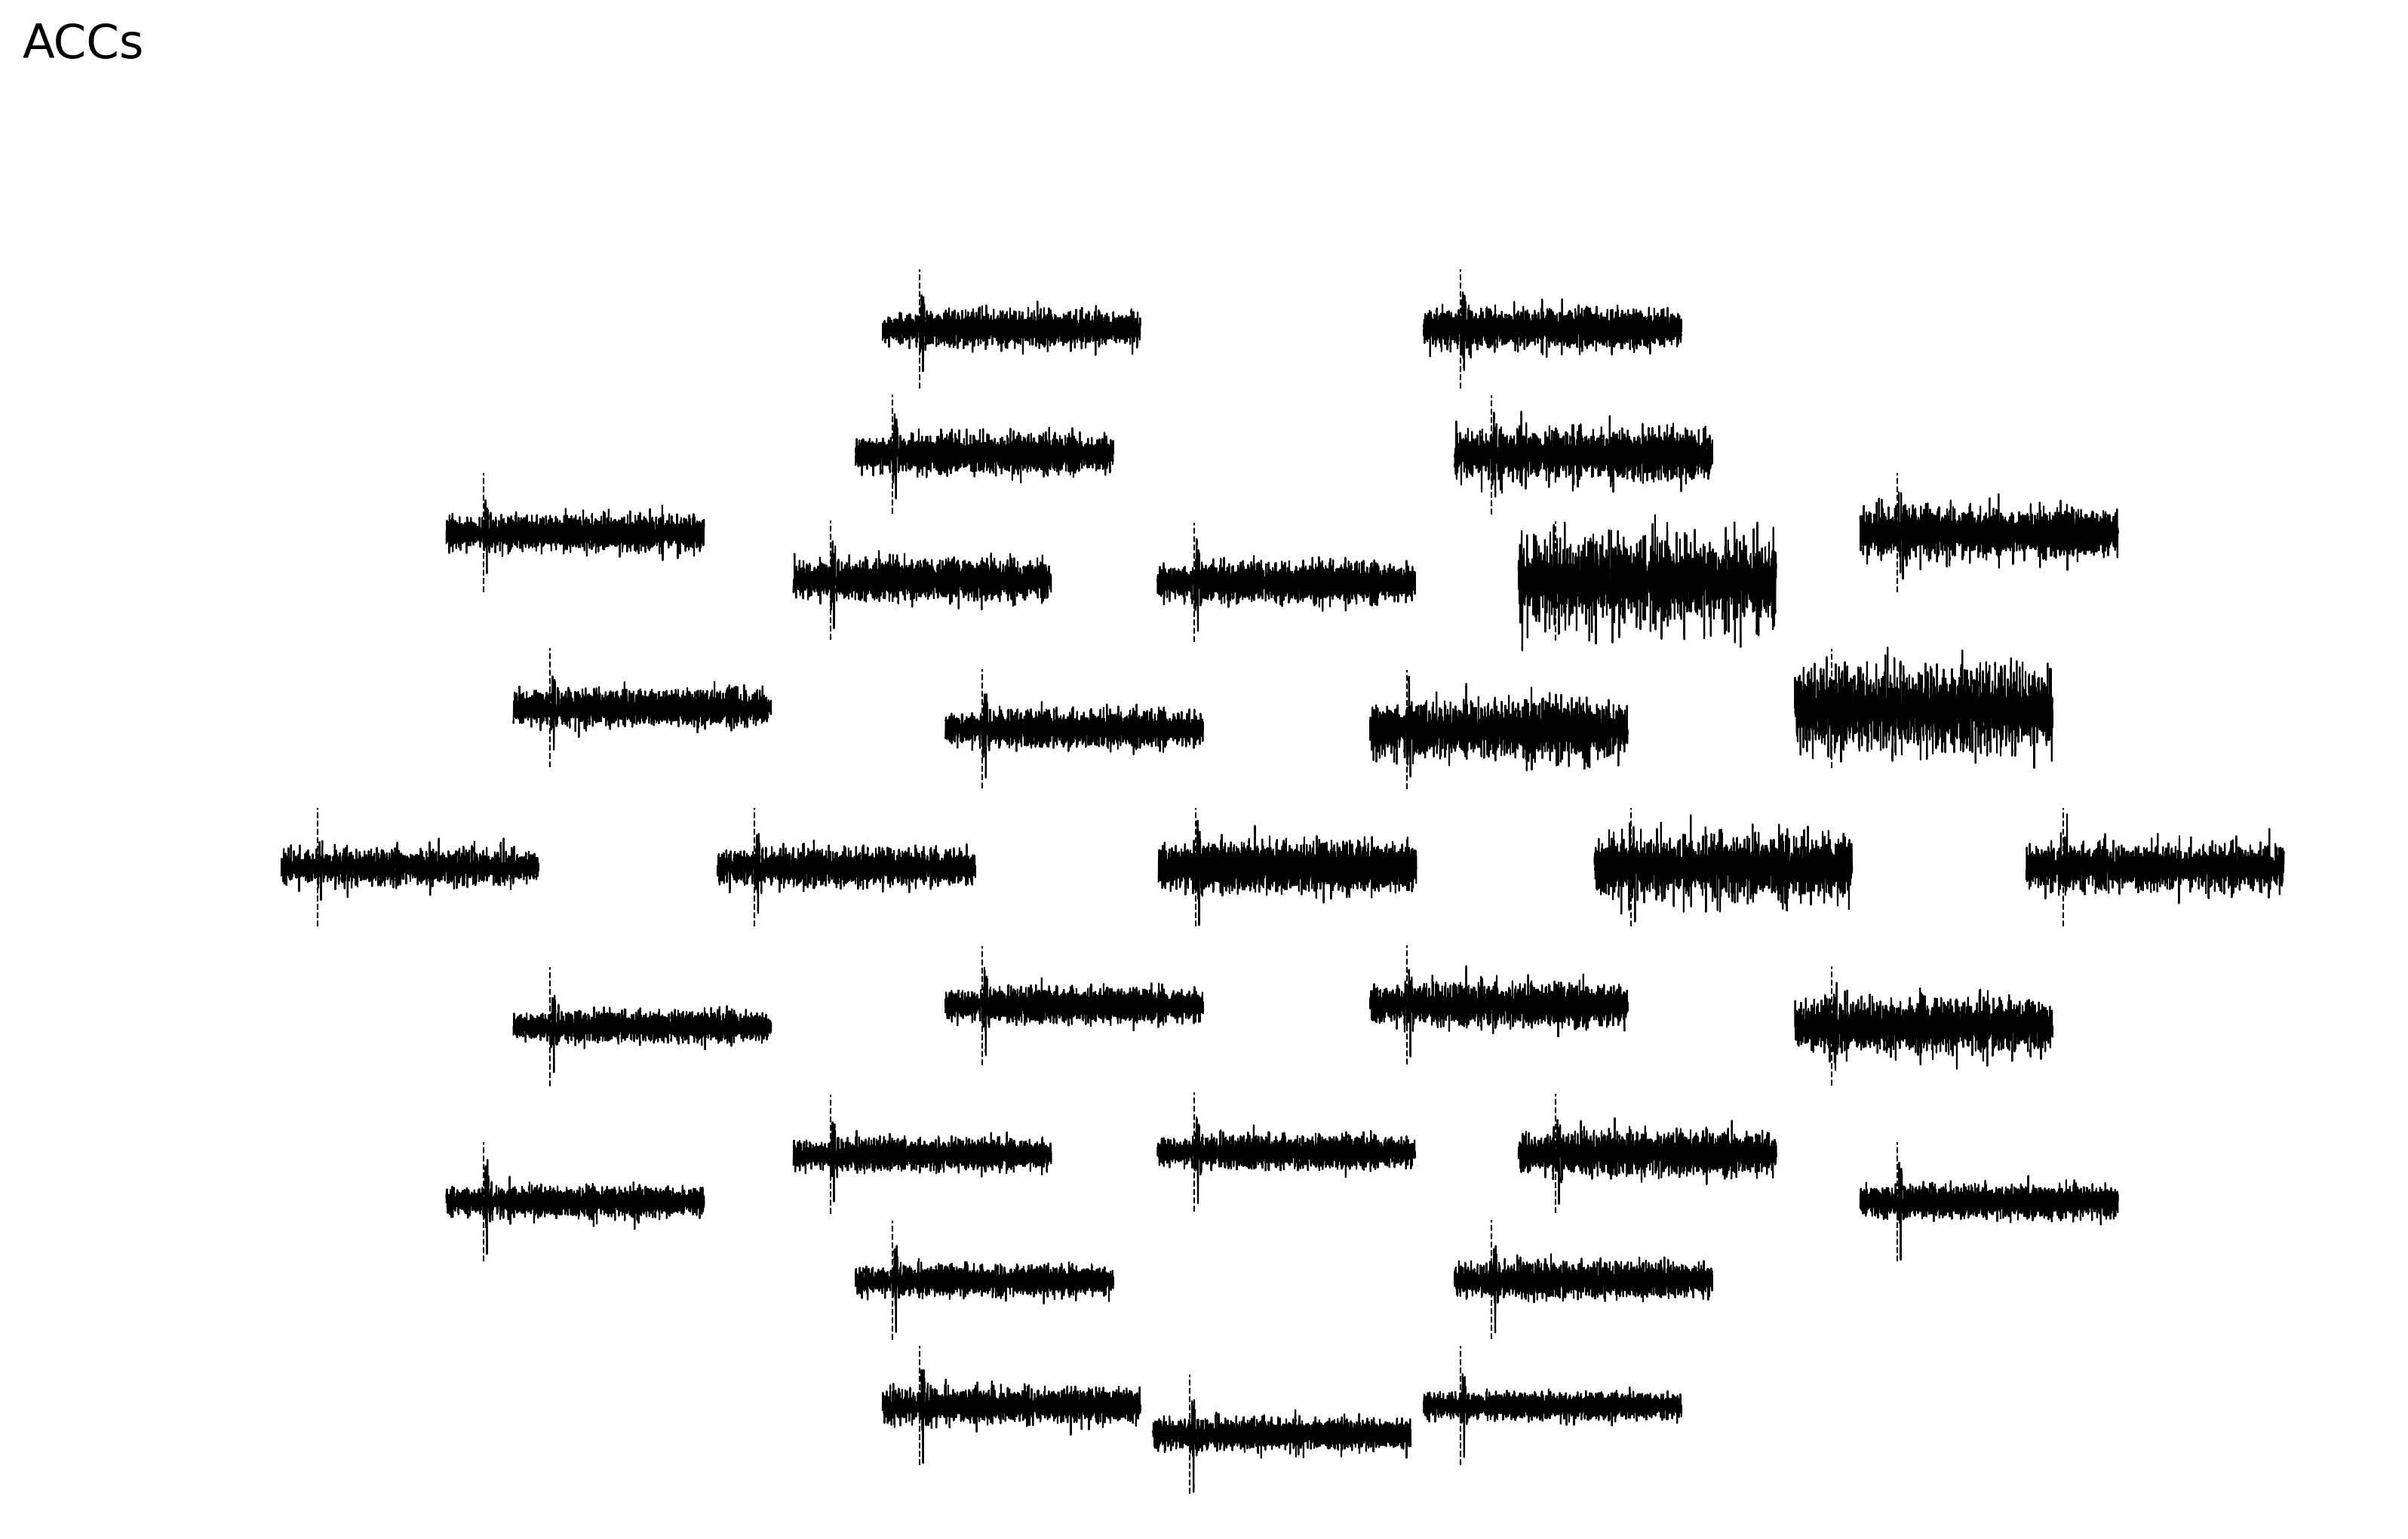

In [11]:
topo_fig = plt.figure();
topo_fig.clear();
# plt.rcParams.update({'figure.figsize': (4,4)})
# plt.rcParams.update({'lines.linewidth': 1})
topo_fig = plt.figure(dpi = 300)
ax = plt.gca();
# topo_fig = erp_up.plot_topo(ylim = dict(eeg=[-4,4]),legend=False, axes = ax,title = 'ACCs', color = 'purple');
topo_fig = comb.plot_topo(ylim = dict(eeg=[-2,2.]),legend=False, axes = ax, title = 'ACCs', color = 'black');
topo_fig.show()
plt.show()

In [12]:
import scipy.io 

os.chdir(out_loc);
scipy.io.savemat(fname, {'time':t_vect,'fs':fs_new,'filt_band':filtband,'mean_p_cap':cap_p, 'std_p_cap':cap_p_std_err,
                         'mean_n_cap':cap_n, 'std_n_cap':cap_n_std_err,
                         'cap_chan_ids':selected_chans,
                         'all_epochs_pos':all_epochs_mean_p,
                         'all_epochs_neg':all_epochs_mean_n,
                        'combined_mean':comb_export});